<a href="https://colab.research.google.com/github/gkv856/util_repo/blob/master/DCGAN_WGAN_GP_CNN_on_MNIST_Image_Generation_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
BS = 256
nz = 100

In [4]:
# Define a transformation to preprocess the data
transform = T.Compose([T.ToTensor(), T.Normalize(mean=(0.1307, ), std=(0.3081, ))])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders to efficiently load the data in batches

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BS, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BS, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 99804142.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75662519.57it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26806092.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14195625.01it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
idx = 4
data = train_dataset[idx]
img, label = data[0], data[1]
print( img[0].max(), img[0].min(), img[0].mean(), img[0].std())
print(img.shape,  label)

tensor(2.8215) tensor(-0.4242) tensor(-0.0473) tensor(0.9472)
torch.Size([1, 28, 28]) 9


In [7]:
for inputs, labels in train_loader:
  print(inputs.shape, labels.shape, inputs[0].min(), inputs[0].max())
  break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor(-0.4242) tensor(2.8088)


In [8]:
from torchvision.utils import make_grid

def visualize_mnist_grid(images,  num_rows=8):

    images = images[: num_rows*4]

    # print(images.shape)

    # Make a grid of images
    grid = make_grid(images, nrow=num_rows)

    # Denormalize the images (undo the normalization)
    grid = grid / 2 + 0.5  # Unnormalize

    # Convert the grid to a NumPy array for plotting
    grid = grid.numpy()

    # Transpose the grid from (C, H, W) to (H, W, C) for Matplotlib
    grid = np.transpose(grid, (1, 2, 0))

    # Display the grid of images using Matplotlib
    plt.imshow(grid)
    plt.axis('off')  # Turn off axis labels
    plt.show()


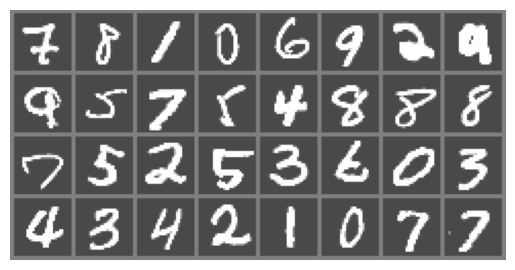

In [9]:
 # You can change the number of images here
 # Get a batch of images
images, labels = next(iter(train_loader))
visualize_mnist_grid(images,  num_rows=8)

In [10]:
def Conv2DTLayer(in_channels, out_channels, kernel_size, stride, padding, act="relu"):
    """
    Create a Convolutional Transpose 2D Layer followed by Batch Normalization and Leaky ReLU activation.

    Args:
        in_channels (int): Number of input channels (i.e., number of feature maps) for the layer.
        out_channels (int): Number of output channels (i.e., number of feature maps) for the layer.
        kernel_size (int or tuple): Size of the convolutional kernel. If a single integer is provided, it's treated as a square kernel size.
        stride (int or tuple): Stride of the convolution operation. If a single integer is provided, it's treated as the same stride in both dimensions.
        padding (int or tuple): Padding to be added to the input feature maps.

    Returns:
        nn.Sequential: A sequential PyTorch module consisting of the following layers:
            - ConvTranspose2d: Convolutional Transpose 2D layer with specified parameters.
            - BatchNorm2d: Batch normalization layer applied to the output of the convolution.
            - LeakyReLU: Leaky Rectified Linear Unit activation function.

    Example:
        # Create a Conv2DTLayer with 3 input channels, 64 output channels, a 4x4 kernel, stride of 2, and padding of 1
        conv2d_layer = Conv2DTLayer(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
    """
    if act == "tanh":
        layer_list = [
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
          nn.Tanh(),
      ]
    else:
      layer_list = [
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(True),
      ]

    # Create a sequential model from the layer list
    seq_model = nn.Sequential(*layer_list)

    return seq_model


In [11]:
class Generator(nn.Module):
    """
    A generative neural network model for image synthesis using transposed convolution layers.

    Parameters:
        nc (int): Number of output channels (e.g., 1 for grayscale, 3 for RGB).
        nz (int): Size of the input noise vector.
        ngf (int): Number of feature maps in the generator's hidden layers.

    Attributes:
        network (nn.Sequential): The generator network architecture composed of transposed convolution layers
                                 followed by batch normalization and ReLU activation functions.

    Methods:
        forward(input): Forward pass through the generator network.

    Example:
        generator = Generator(nc=3, nz=100, ngf=64)
        noise_input = torch.randn(1, 100, 1, 1)  # Input noise tensor
        fake_image = generator(noise_input)  # Generate a fake image
    """

    def __init__(self, nc=1, nz=100, ngf=32):
        """
        Initialize the Generator object with the specified configuration.

        Args:
            nc (int, optional): Number of output channels (default is 1).
            nz (int, optional): Size of the input noise vector (default is 100).
            ngf (int, optional): Number of feature maps in the generator's hidden layers (default is 32).
        """
        super(Generator, self).__init__()


        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        """
        Perform a forward pass through the generator network.

        Args:
            input (torch.Tensor): Input noise tensor of shape (batch_size, nz, 1, 1).

        Returns:
            torch.Tensor: Generated fake image tensor of shape (batch_size, nc, H, W).
        """
        out = self.network(input)
        return out


In [12]:
netG = Generator()
netG = netG.to(device)

In [13]:
def getNoise(batch_size=BS, nDim=nz):
  return torch.randn(batch_size, nDim, 1, 1).to(device)

sample_noise = getNoise()
sample_noise.shape

torch.Size([256, 100, 1, 1])

In [14]:
from torchsummary import summary
summary(netG, input_size=(sample_noise[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         204,800
       BatchNorm2d-2            [-1, 128, 4, 4]             256
              ReLU-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 7, 7]          73,728
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]          32,768
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             512
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 312,256
Trainable params: 312,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

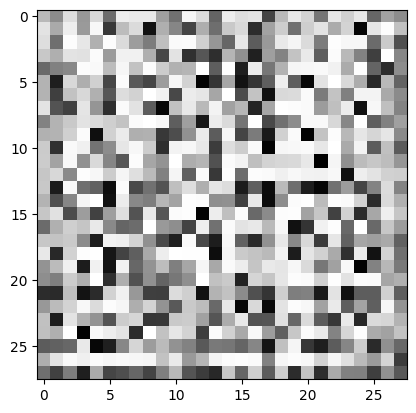

In [15]:
fake_imgs = netG(sample_noise)
fake_imgs.shape
plt.imshow(fake_imgs[0].permute(2, 1, 0).detach().numpy(), cmap="gray")

In [16]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
import imageio
import natsort
from glob import glob

def generate_images(epoch, path, fixed_noise, netG, device):

    num_test_samples = 16
    # Calculate the number of rows and columns for the grid of generated images
    size_figure_grid = int(math.sqrt(num_test_samples))

    # Initialize the title variable
    title = None

    netG.eval()

    generated_fake_images = netG(fixed_noise)
    title = 'DCGAN'


    # Create the directory if it does not exist
    os.makedirs(path, exist_ok=True)

    # Create a figure and axis for displaying the generated images
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))

    # Remove axis labels for all subplots
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    cnt = 0
    for k in range(num_test_samples):
        i = k // size_figure_grid  # Calculate row index
        j = k % size_figure_grid   # Calculate column index
        cnt += 1

        # Clear the current axis and display the generated image
        ax[i, j].cla()
        ax[i, j].imshow(generated_fake_images[k].data.cpu().numpy().reshape(28, 28), cmap='Greys')

    # Set the label for the figure
    label = 'Epoch_{}'.format(epoch + 1)
    fig.text(0.5, 0.04, label, ha='center')  # Add label at the bottom
    fig.suptitle(title)  # Set the title for the entire figure

    # Save the figure with a label as a PNG file
    fig.savefig(path + label + '.png')

def save_gif(path, fps):

    images = glob(path + '*.png')
    images = natsort.natsorted(images)
    gif = []

    for image in images:
        gif.append(imageio.imread(image))

    imageio.mimsave(path+'animated.gif', gif, fps=fps)


In [17]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.3),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.3),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.3),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [18]:
netD = Discriminator()
netD = netD.to(device)

In [19]:
summary(netD, input_size=(fake_imgs[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             512
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          32,768
       BatchNorm2d-4             [-1, 64, 7, 7]             128
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Conv2d-6            [-1, 128, 4, 4]          73,728
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           2,048
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 109,440
Trainable params: 109,440
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.42
Estimated T

In [20]:
outD = netD(fake_imgs)
outD.shape, outD[:10]

(torch.Size([256]),
 tensor([0.5513, 0.4575, 0.6025, 0.5707, 0.4626, 0.4529, 0.5265, 0.4933, 0.6231,
         0.6388], grad_fn=<SliceBackward0>))

In [21]:
def generator_loss(fake_scores):
    # The generator's loss is the negation of the mean discriminator scores for fake samples.
    return -torch.mean(fake_scores)


In [22]:
import torch
import torch.autograd as autograd

def calc_gradient_penalty(discriminator, real_samples, fake_samples, device):
    # Generate random weights for interpolation between real and fake samples.
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)

    # Create interpolated samples by combining real and fake samples.
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Pass interpolated samples through the discriminator.
    interpolated_scores = discriminator(interpolated)

    # Compute gradients of the scores with respect to the interpolated samples.
    gradients = autograd.grad(outputs=interpolated_scores, inputs=interpolated,
                              grad_outputs=torch.ones(interpolated_scores.size(), device=device),
                              create_graph=True, retain_graph=True)[0]

    # Calculate the gradient penalty as the L2 norm of the gradients.
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


In [23]:
def discriminator_loss(real_scores, fake_scores, gradient_penalty, lambda_gp=10):
    # The Wasserstein distance between real and fake distributions.
    wasserstein_distance = torch.mean(real_scores) - torch.mean(fake_scores)

    # Discriminator loss is the negation of the Wasserstein distance plus the gradient penalty term.
    loss = -wasserstein_distance + lambda_gp * gradient_penalty

    return loss

In [24]:
epochs, noise_dim = 100, 100
epochs, BS, noise_dim

(100, 256, 100)

In [25]:
fixed_noise = getNoise()
path = "./gifs/"

In [26]:
import torchvision.utils as vutils

In [27]:

netG = Generator().to(device)
netD = Discriminator().to(device)

epochs = 100
noise_dim = 100

lrG = 0.0001
lrD = 0.0001
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(0.5, 0.999))

num_batches = len(train_loader)
print_every = num_batches // 10  # Print a dot every 10% completion

real_label = 1.
fake_label = 0.

netG.train()
netD.train()

fixed_noise = getNoise()


# Training loop
for epoch in range(epochs):
  for i, (imgs, _) in enumerate(train_loader):
    real_samples = imgs.to(device)  # Move real samples to GPU if available
    curr_bs = real_samples.size(0)

    # Update Discriminator
    optimizer_D.zero_grad()

    # Generate fake samples from the generator
    noise = getNoise(curr_bs)
    fake_samples = netG(noise)

    # Compute discriminator scores for real and fake samples
    real_scores = netD(real_samples)
    fake_scores = netD(fake_samples.detach())

    # Calculate the gradient penalty
    gradient_penalty = calc_gradient_penalty(netD, real_samples, fake_samples, device)

    # Calculate discriminator loss
    d_loss = discriminator_loss(real_scores, fake_scores, gradient_penalty)

    # Update discriminator weights
    d_loss.backward()
    optimizer_D.step()

    # Update Generator
    optimizer_G.zero_grad()

    # Generate fake samples again (updated)
    noise = getNoise(curr_bs)
    fake_samples = netG(noise)

    # Compute discriminator scores for the updated fake samples
    fake_scores = netD(fake_samples)

    # Calculate generator loss
    g_loss = generator_loss(fake_scores)

    # Update generator weights
    g_loss.backward()
    optimizer_G.step()


    if i == 0:
        print(f"\nEpoch [{epoch+1}/{epochs}]", end='', flush=True)

    if (i + 1) % print_every == 0:
        print('.', end='', flush=True)

  print(f"\td_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

  # Save generated images at the end of each epoch

  netG.eval()
  generate_images(epoch, path, fixed_noise, netG, device)
  if (epoch+1) % 5 == 0:
    noise = getNoise()
    gen_imgs = netG(noise)
    visualize_mnist_grid(gen_imgs.cpu(),  num_rows=8)


  with torch.no_grad():
      fake_samples = netG(fixed_noise)  # Use fixed noise to generate consistent images
  vutils.save_image(fake_samples, 'fake_samples_epoch_%03d.png' % (epoch + 1), normalize=True)

  netG.train()

save_gif(path, 25)



Epoch [1/100]

KeyboardInterrupt: ignored

In [ ]:

# for epoch in range(epochs):
#     for i, (real_images, _) in enumerate(train_loader):

#       bs = real_images.shape[0]
#       ##############################
#       #   Training discriminator   #
#       ##############################

#       netD.zero_grad()
#       real_images = real_images.to(device)
#       label = torch.full((bs,), real_label, device=device)

#       output = netD(real_images)
#       lossD_real = criterion(output, label)
#       lossD_real.backward()
#       D_x = output.mean().item()

#       noise = torch.randn(bs, 100, 1, 1, device=device)
#       fake_images = netG(noise)
#       label.fill_(fake_label)
#       output = netD(fake_images.detach())
#       lossD_fake = criterion(output, label)
#       lossD_fake.backward()
#       D_G_z1 = output.mean().item()
#       lossD = lossD_real + lossD_fake
#       optimizerD.step()

#       ##########################
#       #   Training generator   #
#       ##########################

#       netG.zero_grad()
#       label.fill_(real_label)


#       output = netD(fake_images)
#       lossG = criterion(output, label)
#       lossG.backward()
#       D_G_z2 = output.mean().item()
#       optimizerG.step()



#       if i == 0:
#         print(f"\nEpoch [{epoch+1}/{epochs}]", end='', flush=True)

#       if (i + 1) % print_every == 0:
#           print('.', end='', flush=True)

#     print(f"\td_loss: {lossD.item():.4f}, g_loss: {lossG.item():.4f}")

#     netG.eval()
#     generate_images(epoch, path, fixed_noise, netG, device)
#     netG.train()

#     if (epoch+1) % 5 == 0:
#         netG.eval()
#         noise = getNoise()
#         gen_imgs = netG(noise)
#         visualize_mnist_grid(gen_imgs.cpu(),  num_rows=8)
#         # visualize_mnist_grid(real_images.cpu(), torch.ones_like(gen_imgs).cpu(), num_rows=8)

#         netG.train()

# save_gif(path, 30)

In [ ]:
# noise = torch.randn((BS, noise_dim, 1, 1))
noise = getNoise()
imgs = netG(noise)

# gen_imgs = gen_model(noise)
visualize_mnist_grid(imgs.cpu(),  num_rows=8)

In [ ]:
imgs[0].min(), imgs[0].max(), imgs[0].shape